In [21]:
import os
import numpy as np
import scipy as sp
from tqdm import tqdm
from time import time

from src.utils import *

In [31]:
dataset = "03"
filename = os.path.join(os.getcwd(), f"data/{dataset}.npz")

In [32]:
ts, features, linear_velocity, angular_velocity, K, b, imu_T_cam = load_data(filename)

In [33]:
imu_T_cam

array([[ 0.03717833, -0.09861822,  0.9944306 ,  1.5752681 ],
       [ 0.99926755, -0.00535534, -0.03789026,  0.00439141],
       [ 0.00906218,  0.99511094,  0.09834688, -0.65      ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [34]:
IMU_flip = np.zeros((3,3))
IMU_flip[0,0] = 1
IMU_flip[1,1] = -1
IMU_flip[2,2] = -1

imu_T_cam[:3,:3] = IMU_flip @ imu_T_cam[:3,:3]
imu_T_cam

array([[ 0.03717833, -0.09861822,  0.9944306 ,  1.5752681 ],
       [-0.99926755,  0.00535534,  0.03789026,  0.00439141],
       [-0.00906218, -0.99511094, -0.09834688, -0.65      ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [35]:
def get_world_coordinates(K, b, imu_T_cam, T, pixel_coordinates):
    Fsu = K[0,0]
    Fsv = K[1,1]
    Cu = K[0,2]
    Cv = K[1,2]

    uL = pixel_coordinates[0,:]
    vL = pixel_coordinates[1,:]
    uR = pixel_coordinates[2,:]
    vR = pixel_coordinates[3,:]

    z = Fsu * b / (uL - uR)
    x = z * (uL - Cu) / Fsu
    y = z * (vL - Cv) / Fsv
    ones = np.ones_like(z)

    camera_h_coordinates = np.stack((x,y,z,ones))
    imu_h_coodinates = imu_T_cam @ camera_h_coordinates
    world_h_coordinates = T @ imu_h_coodinates

    return world_h_coordinates


__IMU Localization via EKF prediction__

In [36]:
tau = np.zeros_like(ts)
tau[0, 1:] = ts[0, 1:] - ts[0, :-1]
tau = np.squeeze(tau)

gen_velocity = np.vstack((linear_velocity, angular_velocity))

# twist = axangle2twist(gen_velocity.T)
# motion_perturb = twist * tau[:, None, None]
# exp_motion_perturb = np.zeros_like(motion_perturb)
# for i in range(motion_perturb.shape[0]):
#     exp_motion_perturb[i,:,:] = sp.linalg.expm(motion_perturb[i,:,:])

exp_motion_perturb = axangle2pose(gen_velocity.T * tau[:,None])

ad_twist = axangle2adtwist(gen_velocity.T)
mean_perturb = ad_twist * -tau[:, None, None]
exp_mean_perturb = np.zeros_like(mean_perturb)
for i in range(mean_perturb.shape[0]):
    exp_mean_perturb[i,:,:] = sp.linalg.expm(mean_perturb[i,:,:])

In [37]:
def find_poses_landmarks():

    mu = np.eye(4,4)
    sigma = np.eye(6,6)
    delta_mu = np.random.multivariate_normal(mean=np.zeros((6,)), cov=sigma)

    noise_cov = np.eye(6,6) * 0.01

    trajectory = [mu]
    landmarks = np.zeros((3, features.shape[1]))
    
    for t_idx in tqdm(range(1, tau.shape[0])):
        mu = trajectory[-1]
        noise = np.random.multivariate_normal(mean=np.zeros((6,)), cov=noise_cov)
        
        # Motion model
        mu_t = mu @ exp_motion_perturb[t_idx,:,:]
        delta_mu_t = exp_mean_perturb[t_idx,:,:] @ delta_mu + noise

        sigma_t = exp_mean_perturb[t_idx,:,:] @ sigma @ exp_mean_perturb[t_idx,:,:].T + noise_cov

        trajectory.append(mu_t)
        delta_mu = delta_mu_t
        sigma = sigma_t

        pixel_coords = features[:,:,t_idx]
        valid1 = np.logical_and(pixel_coords[0,:] != -1, pixel_coords[1,:] != -1)
        valid2 = np.logical_and(pixel_coords[2,:] != -1, pixel_coords[3,:] != -1)
        valid = np.logical_and(valid1, valid2)
        pixel_coords = pixel_coords[:,valid]

        world_h_coords = get_world_coordinates(K, b, imu_T_cam, mu_t, pixel_coords)
        landmarks[:, valid] = world_h_coords[:3,:]

    poses = np.stack(trajectory)
    poses = poses.transpose((1,2,0))

    return poses, landmarks

poses, landmarks = find_poses_landmarks()


100%|██████████| 1009/1009 [00:00<00:00, 2654.34it/s]


In [38]:
def remove_landmark_outliers(landmarks):
    v = np.logical_and(np.logical_and(landmarks[0,:] > -1200, landmarks[0,:] < 600), np.logical_and(landmarks[1,:] > -750, landmarks[1,:] < 500))
    clipped_landmarks = landmarks[:,v]
    return clipped_landmarks

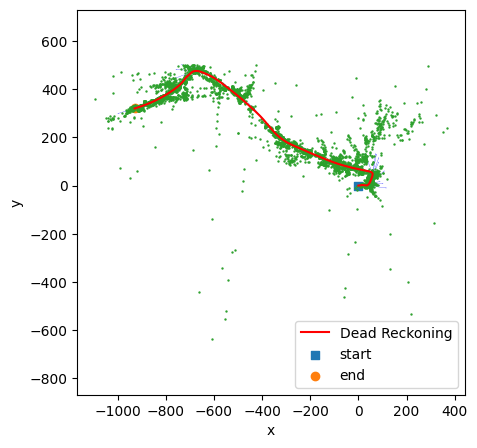

In [39]:
clipped_landmarks = remove_landmark_outliers(landmarks)
fig, ax = visualize_trajectory_2d(poses,clipped_landmarks,path_name="Dead Reckoning",show_ori=True)

In [40]:
fig.savefig(f"results/pose-track-{dataset}.png", dpi=600)

__Landmark mapping via EKF update__

In [41]:
def get_valid_landmarks_and_mean():
    landmark_mu = np.zeros((3, features.shape[1]))
    valid_landmarks = []
    for t_idx in tqdm(range(features.shape[2])):
        T_t = poses[:,:,t_idx]
        
        pixel_coords = features[:,:,t_idx]
        valid1 = np.logical_and(pixel_coords[0,:] != -1, pixel_coords[1,:] != -1)
        valid2 = np.logical_and(pixel_coords[2,:] != -1, pixel_coords[3,:] != -1)
        valid = np.logical_and(valid1, valid2)

        world_h_coords = np.zeros((4, pixel_coords.shape[1]))
        world_h_coords[:, valid] = get_world_coordinates(K, b, imu_T_cam, T_t, pixel_coords[:,valid])

        valid_landmark = landmark_mu == np.zeros((3,1))
        valid_landmark = np.sum(valid_landmark, axis=0) == 3

        landmark_mu[:,valid_landmark & valid] = world_h_coords[:3, valid_landmark & valid]

        valid_landmarks.append(np.where(valid)[0])
    return valid_landmarks, landmark_mu

valid_landmarks, landmark_mu = get_valid_landmarks_and_mean()

100%|██████████| 1010/1010 [00:00<00:00, 2568.01it/s]


In [42]:
landmark_mu_flattened = landmark_mu.T.reshape(-1)
landmark_cov = np.eye(landmark_mu_flattened.shape[0], landmark_mu_flattened.shape[0])

Ks = np.vstack((K, np.zeros(3)))
Ks = np.hstack((Ks, np.zeros((4,1))))
Ks[3,:] = Ks[1,:]
Ks[2,:] = Ks[0,:]
Ks[2,3] = -Ks[0, 0] * b

P = np.hstack((np.eye(3,3), np.zeros((3,1))))
Ks, P

(array([[ 552.554261 ,    0.       ,  682.049453 ,    0.       ],
        [   0.       ,  552.554261 ,  238.769549 ,    0.       ],
        [ 552.554261 ,    0.       ,  682.049453 , -331.5325566],
        [   0.       ,  552.554261 ,  238.769549 ,    0.       ]]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]]))

In [43]:
observation_noise_cov = np.eye(4,4) * 6

for t_idx in tqdm(range(ts.shape[1])):
    T_t = poses[:,:,t_idx]
    valid = valid_landmarks[t_idx]
    Nt = valid.shape[0]
    
    obs = features[:, valid, t_idx]
    
    landmark_mu_coords_t = np.ones((3 * Nt))
    landmark_cov_t = np.zeros((3*Nt, 3*Nt))
    for i in range(Nt):
        landmark_mu_coords_t[3*i:3*i+3] = landmark_mu_flattened[3*valid[i]: 3*valid[i]+3]
        landmark_cov_t[3*i:3*i+3, 3*i:3*i+3] = landmark_cov[3*valid[i]:3*valid[i]+3, 3*valid[i]:3*valid[i]+3]

    landmark_mu_h_coords_t = landmark_mu_coords_t.reshape((-1,3)).T
    landmark_mu_h_coords_t = np.vstack((landmark_mu_h_coords_t, np.ones(landmark_mu_h_coords_t.shape[1])))
    optical_h_coords = np.linalg.inv(imu_T_cam) @ np.linalg.inv(T_t) @ landmark_mu_h_coords_t
    normalized_optical_coords = optical_h_coords / optical_h_coords[2,:]

    predicted_obs = Ks @ normalized_optical_coords
    innovation = obs - predicted_obs

    jacobian = projectionJacobian(predicted_obs.T)
    H_t = Ks @ jacobian @ np.linalg.inv(imu_T_cam) @ np.linalg.inv(T_t) @ P.T

    H = np.zeros((4*Nt, 3*Nt))
    observation_noise_cov_stacked = np.zeros((4*Nt, 4*Nt))
    for i in range(valid.shape[0]):
        H[4*i:4*i+4,3*i:3*i+3] = H_t[i,:,:]
        observation_noise_cov_stacked[4*i:4*i+4, 4*i:4*i+4] = observation_noise_cov

    Kalman_gain = landmark_cov_t @ H.T @ np.linalg.inv(H @ landmark_cov_t @ H.T + observation_noise_cov_stacked)

    landmark_mu_coords_t = landmark_mu_coords_t + np.squeeze(Kalman_gain @ innovation.T.reshape((-1,1)))
    landmark_cov_t = (np.eye(3*Nt, 3*Nt) - Kalman_gain @ H) @ landmark_cov_t

    for i in range(Nt):
        landmark_mu_flattened[3*valid[i]: 3*valid[i]+3] = landmark_mu_coords_t[3*i:3*i+3]
        landmark_cov[3*valid[i]:3*valid[i]+3, 3*valid[i]:3*valid[i]+3] = landmark_cov_t[3*i:3*i+3, 3*i:3*i+3]

predicted_landmarks = landmark_mu_flattened.reshape((-1,3)).T

100%|██████████| 1010/1010 [00:13<00:00, 73.88it/s] 


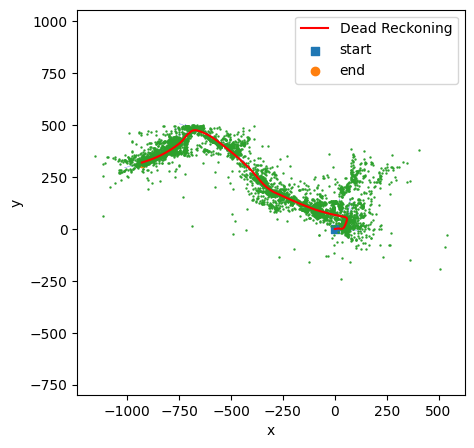

In [44]:
clipped_predicted_landmarks = remove_landmark_outliers(predicted_landmarks)
fig, ax = visualize_trajectory_2d(poses, clipped_predicted_landmarks, path_name="Dead Reckoning", show_ori=True)

In [45]:
fig.savefig(f"results/landmark-mapping-{dataset}.png", dpi=600)

__Combined SLAM__

In [153]:
step = 50

landmarks_estimate = remove_landmark_outliers(landmark_mu[:,::step])
landmark_mu_flattened = landmarks_estimate.T.reshape(-1)
m3 = landmark_mu_flattened.shape[0]

combined_cov_t = np.eye(m3 + 6, m3 + 6) * 0
motion_noise_cov = np.eye(6,6) * 0
motion_noise_cov[3:,3:] = np.eye(3,3) *  0
observation_noise_cov = np.eye(4,4) * 5

slam_robot_poses = [np.eye(4,4)]
robot_pose_delta_t = np.random.multivariate_normal(mean = np.zeros((6,)), cov = combined_cov_t[-6:,-6:])

for t_idx in tqdm(range(1, ts.shape[1])):
    pose_t = slam_robot_poses[-1]

    # Prediction step
    noise = np.random.multivariate_normal(mean=np.zeros((6,)), cov=motion_noise_cov)
    velocity = gen_velocity[:,t_idx-1] + noise
    
    pred_pose_t_1 = pose_t @ axangle2pose(tau[t_idx] * velocity)
    # robot_pose_delta_t_1 = exp_mean_perturb[t_idx,:,:] @ robot_pose_delta_t + noise

    F = sp.linalg.expm(-tau[t_idx] * axangle2adtwist(velocity))

    # Prediction of covariance
    combined_cov_t[-6:,-6:] = F @ combined_cov_t[-6:,-6:] @ F.T + motion_noise_cov
    combined_cov_t[:m3,-6:] = combined_cov_t[:m3,-6:] @ F.T
    combined_cov_t[-6:,:m3] = F @ combined_cov_t[-6:,:m3]

    # Observation Prediction
    all_obs = features[:, ::step, t_idx]

    # Pick only visible
    cols = np.where(all_obs != np.array([[-1,-1,-1,-1]]).T)[1]
    valid = cols[:cols.shape[0]//4]
    Nt = valid.shape[0]

    obs = all_obs[:, valid]
    
    landmark_mu_coords_t = np.ones((3 * Nt))
    for i in range(Nt):
        landmark_mu_coords_t[3*i:3*i+3] = landmark_mu_flattened[3*valid[i]: 3*valid[i]+3]

    landmark_mu_h_coords_t = landmark_mu_coords_t.reshape((-1,3)).T
    landmark_mu_h_coords_t = np.vstack((landmark_mu_h_coords_t, np.ones(landmark_mu_h_coords_t.shape[1])))
    camera_h_coords = np.linalg.inv(pose_t) @ landmark_mu_h_coords_t
    optical_h_coords = np.linalg.inv(imu_T_cam) @ camera_h_coords
    normalized_optical_coords = optical_h_coords / optical_h_coords[2,:]

    predicted_obs = Ks @ normalized_optical_coords
    innovation = obs - predicted_obs

    # Jacobian calculation
    jacobian = projectionJacobian(predicted_obs.T)
    pose_H_t = -Ks @ jacobian @ np.linalg.inv(imu_T_cam) @ get_dot_circ(camera_h_coords.T)
    landmark_H_t = Ks @ jacobian @ np.linalg.inv(imu_T_cam) @ np.linalg.inv(pose_t) @ P.T

    H = np.zeros((4*Nt, m3 + 6))
    observation_noise_cov_stacked = np.zeros((4*Nt, 4*Nt))
    for i in range(Nt):
        H[4*i:4*i+4,3*valid[i]:3*valid[i]+3] = landmark_H_t[i,:,:]
        H[4*i:4*i+4,-6:] = pose_H_t[i,:,:]
        observation_noise_cov_stacked[4*i:4*i+4, 4*i:4*i+4] = observation_noise_cov
    
    # Kalman_gain = combined_cov_t @ H.T @ np.linalg.inv(H @ combined_cov_t @ H.T + observation_noise_cov_stacked)

    Kalman_gain = np.linalg.solve(H @ combined_cov_t @ H.T + observation_noise_cov_stacked, H @ combined_cov_t)
    Kalman_gain = Kalman_gain.T
    
    # Update step
    updates = np.squeeze(Kalman_gain @ innovation.T.reshape((-1,1)))

    landmark_mu_flattened = landmark_mu_flattened + updates[:m3]
    update_pose_t_1 = pred_pose_t_1 @ axangle2pose(updates[m3:])
    combined_cov_t = (np.eye(m3+6, m3+6) - Kalman_gain @ H) @ combined_cov_t

    slam_robot_poses.append(update_pose_t_1)

slam_robot_poses = np.stack(slam_robot_poses)
slam_robot_poses = slam_robot_poses.transpose((1,2,0))
predicted_landmarks = landmark_mu_flattened.reshape((-1,3)).T


100%|██████████| 3025/3025 [01:45<00:00, 28.70it/s]


In [147]:
diff = landmarks_estimate - predicted_landmarks
np.max(diff), np.min(diff)

(24.230981074156944, -27.654046564116356)

In [144]:
pdiff = poses[:3,:3,:] - slam_robot_poses[:3,:3,:]
np.min(pdiff), np.max(pdiff)

(-1.9182201850900331, 1.7884572671210104)

In [66]:
np.save("slam_robot_poses.npy", slam_robot_poses)
np.save("landmarks.npy", predicted_landmarks)

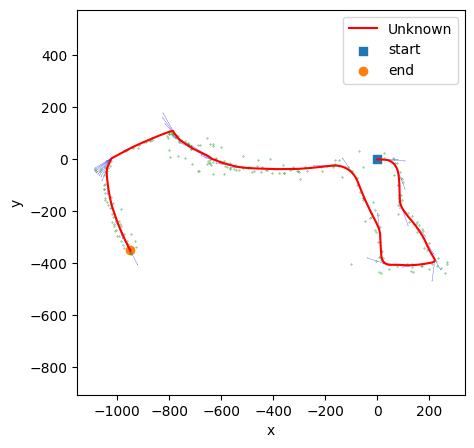

In [154]:
# clipped_predicted_landmarks = remove_landmark_outliers(predicted_landmarks)
# fig, ax = visualize_trajectory_2d(slam_robot_poses, clipped_predicted_landmarks, show_ori=True)

# clipped_predicted_landmarks = remove_landmark_outliers(predicted_landmarks)
fig, ax = visualize_trajectory_2d(slam_robot_poses, predicted_landmarks, show_ori=True)

In [37]:
predicted_landmarks.shape

(3, 266)

In [42]:
remove_landmark_outliers(landmark_mu).shape

(3, 13286)

In [ ]:

    # visible = cols[:cols.shape[0]//4]
    # Nt = visible.shape[0]

    # valid_obs = []
    # valid_idx = []
    # for i in visible:
    #     coords = landmark_mu_flattened[3*i:3*i+3] - pred_pose_t_1[:3,3]
    #     if not np.any(np.abs(coords)>10000):
    #         valid_obs.append(coords)
    #         valid_idx.append(i)
    
    # if not valid_obs:
    #     # There was no valid observation so no update step
    #     slam_robot_poses.append(pred_pose_t_1)
    #     continue
    
    # landmark_mu_coords_t = np.stack(valid_obs)
    # valid = np.array(valid_idx)
    # Nt = valid.shape[0]

    # # Valid observations
    # obs = all_obs[:, valid]

    # landmark_mu_h_coords_t = landmark_mu_coords_t.T